# Load the Model

This script will load the previously trained ML model and try to use it to predict the output frequency for different data conditons.

First we will be using the model trained on a stationary heart beat to detect a model that has a moving heart beat. The data loaded below has a heart beat which is linearly chirping at a rate of 1 Hz in 10 seconds. 

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import Input as Input
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D,Conv1D
from keras.models import Sequential
from keras.layers import Dropout
from keras import layers
from keras.layers import BatchNormalization
import h5py
import scipy.signal as sig
from scipy import signal
print(keras.__version__)

2.4.3


# Load data

The cell below loads the .mat file which contains the data. If this does not work make sure the .mat was saved as -v7.3, which is in the h5py data format. If it is not, resave it or change this code. 

In [2]:
f = h5py.File('ML_phaseFull_HRV.mat','r') 
#f = h5py.File('ML_HRV_honly_fs500_1.mat','r') 

f = h5py.File('ML_HRV_full_fs500_long_1.mat','r') 
arrays = {}

for k, v in f.items():
    arrays[k] = np.array(v)

    

In [3]:
def getSpec(x,win,winSize,fs,fLimit,y_dat,out,inner):
    #Generate Spectrogram
    f, t, Sxx = signal.spectrogram(x,window=win,nperseg=winSize ,fs = fs,noverlap=winSize - 15,nfft= 10000) #Find spectrogram with high fft count
    spec = Sxx[0:fLimit,:] #We only need FFT from 0 to 6 ish Hz which is about the first 100 samples at fs=500
    f = f[0:fLimit]
    idx=np.int0(t*fs)
    if inner != -1:
        y=y_dat[idx,out,inner]
    else:
        y = y_dat[out,idx]
    return spec,f,y,t

# Extract data into usable form
The data is in a dict by default, for ease of use lets put it into several different variables. X_dat should be a matrix of the data which is 100k by 2k where there are 100k data samples each are 2k long. 

In [4]:
print(arrays.keys())
datOut= arrays['datOut']

numOfDat = datOut.shape[0]

heartLabels = arrays['fhActual']

print(heartLabels.shape)
heartLabels = heartLabels[:,0:]

y_dat = heartLabels

respLabels = arrays['frActual']
respLabels = respLabels.transpose()
respLabels = respLabels[:,0:numOfDat]
#print(datOut.shape) # 20 thousand different trials each is 16k samples long. +


#datLabels = np.empty((2,numOfDat))
#datLabels[0,:] = respLabels
#datLabels[1,:] = heartLabels

#datLabels= datLabels.transpose()
tNum = datOut.shape[0]

x_dat = datOut[:,0:]
#y_dat = datLabels[:,:] 



# convert the data to the right type
x_dat = x_dat.astype('float32')


print('x_dat shape:', x_dat.shape)
print(x_dat.shape[0], 'samples')
print('y_dat shape:', y_dat.shape)

lenDat = x_dat.shape[1]
numDat = x_dat.shape[0]

dict_keys(['datOut', 'fhActual', 'frActual', 't'])
(10, 50001)
x_dat shape: (10, 50001)
10 samples
y_dat shape: (10, 50001)


# Load ML model

Load the previously trained ML model

Current model uses 1900  data samples for 1 classificaiton (freq estimation)

In [18]:
model = keras.models.load_model('Model_fs500_specModel_RespInc/')
model = keras.models.load_model('Model_fs500_honly_500/')
lenModel = 500
fs =500

testRunNum = 8
print(x_dat.shape)


(10, 50001)


In [19]:
winSize = 2048  #This is the window size (found to work best for fs = 500)
fLimit = 100
win = signal.get_window('hamming',winSize) #Hamming window



testRunNum = 1

x= x_dat[testRunNum,:]
spec,f,y,t = getSpec(x,win,winSize,fs,fLimit,y_dat,testRunNum,-1)

spec = spec
print(spec.shape)
print(t.shape)
print(y.shape)

(100, 3197)
(3197,)
(3197,)


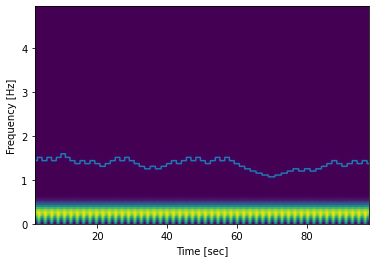

In [20]:


plt.pcolormesh(t,f,spec, shading='gouraud') #Plot it to confirm (dont do this when actually finding it (duh))
plt.plot(t,y)
plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')

plt.show()

In [31]:

if spec.shape[0] == lenModel:
    spec = np.transpose(spec)



k=60


inDat = spec[:,k]
print(inDat.shape)
freqEst = model.predict(spec[:,k].transpose())



(100,)


ValueError: in user code:

    /home/joe/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/joe/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/joe/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/joe/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/joe/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/joe/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/joe/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/joe/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/joe/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 600 but received input with shape (None, 1)


In [13]:

#np.savetxt("foo.csv", freqEstFilt, delimiter=",")

lenEst = len(freqEst)
t = np.linspace(0,40,lenEst)



plt.plot(t,(freqEst))
plt.plot(t,y)
plt.ylabel('Frequency')
plt.xlabel('time (s)')
plt.legend(['Predicted Freqeuncy','Actual Frequency'])
plt.title('Heart Rate Frequency Estimate Comparison')
plt.show()

mseFreq = np.mean(np.power(y-freqEst,2))
print('MSE of freq Est: ',mseFreq)

NameError: name 'freqEst' is not defined